In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

# Anomalies

In this homework we will look at some simple examples of detecting anomalies in time series. But first, let's try to define, what anomaly is.

In general, **anomaly** is an observable behaviour of the system, which contradicts the underlying dynamics, which we believe is driving the system. Of course, any observable, normal or anomalous, is generated by underlying system dynamics. The real reason we consider some behaviours as normal and some as anomalous is that we use not a real dynamics to describe the system, but either some model, or we want system to demostrate certain desired behaviour.

For example:

- unusually high power consumption in electrical grid may be caused by unusual weather conditions for a certain season, and is thus an absolutely explainable, but grid operator still considers this situation as an anomaly, because unusually high consumption is not a desirable behaviour,
- presense of unusual patterns in sensor reading of industrial equipment may be an indication of some failure coming. In this case, anomaly is not manifested as some extremely high or low way, but rather as an unusual pattern.

In this homework we will consider two datasets:

- [hourly energy consumption data from PJM transmission operator](https://www.kaggle.com/robikscube/hourly-energy-consumption),
- ECG data from [MIT-BIH Arrhythmia Database](https://www.kaggle.com/mondejar/mitbih-database).

# Data

For the first exercise, we will take specific area, served by Commonwealth Edison energy producer. The area is Chicago and part of Illinois. We will look at the data to understand, when consumption is anomalous and will try to explain this anomalies to some extent.

In [3]:
data = pd.read_csv('COMED_hourly.csv',
                   parse_dates=["Datetime"],
                   index_col="Datetime")

In [4]:
data.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


Let's clean-up the field a bit first:

In [5]:
data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
data.index.name = "dt"
data.head()

,cons_mw
dt,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


## Quick exploration

Data definitely demostrates strong seasonality with consumption being higher at summer (air conditioning, apperantly) and during winter (electrical heating, lights etc.):

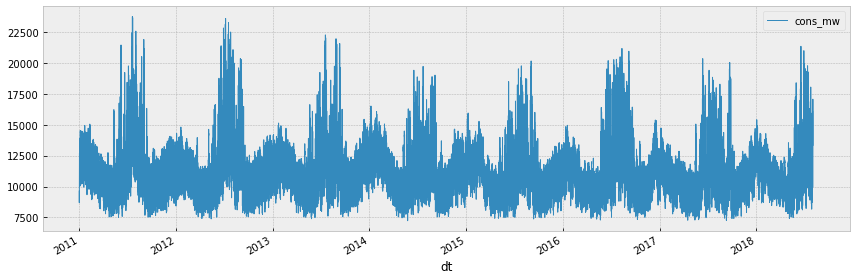

In [6]:
plt.figure(figsize=(12,4))
data.plot(linewidth=1, ax=plt.gca())
plt.tight_layout()

If we try to calculate rolling average of the data, we will fail, cause original data is not ordered:

In [7]:
data=data.sort_index()
data.rolling("7D").mean()

,cons_mw
dt,
2011-01-01 01:00:00,9631.000000
2011-01-01 02:00:00,9452.000000
2011-01-01 03:00:00,9305.000000
2011-01-01 04:00:00,9164.000000
2011-01-01 05:00:00,9070.000000
...,...
2018-08-02 20:00:00,12035.815476
2018-08-02 21:00:00,12045.607143
2018-08-02 22:00:00,12054.297619


# Naive anomalies detection

The first and the most simple way to catch unusually high or low values is to just look at rolling average and rolling standard deviation. The assumation is that for a reasonably short period we can use usual statistical approaches, and to say
> if it's outside 3$\sigma$, it's an anomaly

is still somewhat reliable. Let's look at the data at a weekly scale:

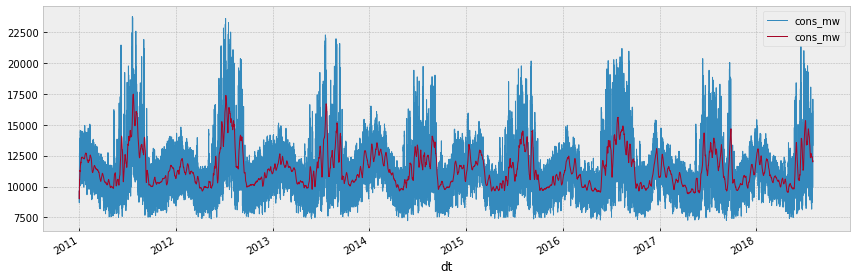

In [8]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

data.rolling("7D").mean().plot(linewidth=1, ax=plt.gca())

plt.legend(loc=0)
plt.tight_layout()

If we look at the same data on a monthly scale and add "normal" range ($3\sigma$ from rolling average in any direction), we'll start to see hours, which go to high:

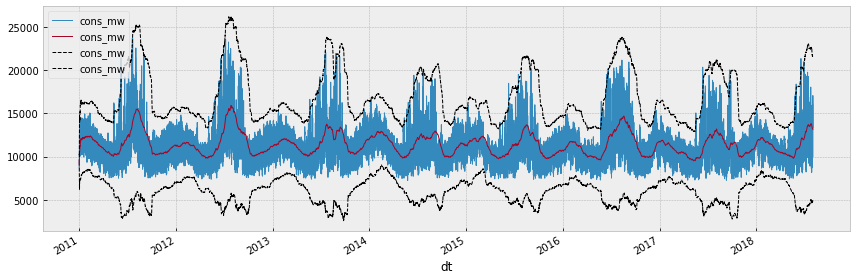

In [9]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

(data
 .rolling("30D")
 .mean()
 .plot(linewidth=1, ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()+3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()-3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

plt.legend(loc=0)
plt.tight_layout()

Let's create a funtion, which searches for such points and creates new dataframe with anomaly indication:

In [10]:
def detect_anomalies(series, window, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""

    series_mean = series.rolling(window).mean()
    series_std = series.rolling(window).std()

    result = pd.concat([series,
                        series_mean.rename("_".join([series.name, "rmean"]))],
                       axis=1)
    result = result.join(series_std.rename("_".join([series.name, "rstd"])))
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

In [11]:
data_an = detect_anomalies(data["cons_mw"], "30D", 3.)

In [12]:
data_an.head()

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.0,NaN,0
2011-01-01 02:00:00,9273.0,9452.0,253.144228,0
2011-01-01 03:00:00,9011.0,9305.0,311.236245,0
2011-01-01 04:00:00,8741.0,9164.0,379.608570,0
2011-01-01 05:00:00,8694.0,9070.0,390.201230,0


In [13]:
def plot_anomalies(df, d_col, m_col, s_col, a_col, factor):
    """Plot data and annotations."""

    plt.figure(figsize=(12,4))

    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plot rolling average
    df[m_col].plot(linewidth=1, ax=plt.gca())

    # Plot "normal" range
    (df[m_col]+factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())
    (df[m_col]-factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())

    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0,
                                     marker="x",
                                     markersize=2,
                                     c="yellow", linestyle="--",  ax=plt.gca())


    plt.tight_layout()

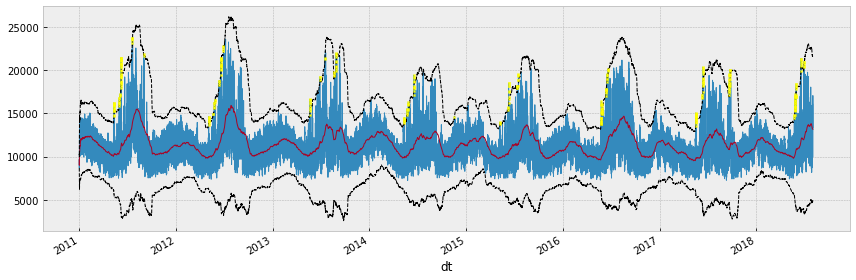

In [14]:
plot_anomalies(data_an, "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

Although some of the caught anomalies look ok, we immediately can spot several problems:
    
- we definitely underestimate the upper bound of the range, when rolling average goes up very fast,
- we definitely overestimate the upper bound of the range, when rolling average goes down very fast.

This all happens because rolling average is "delayed" relative to underlying time series. Another, probably more severe, problem is non-stationarity, and especially seasonality. Depending on the structure, by doing such a naive anomaly detection we may miss a lot of real anomalies. Can we do better?

# Extracting trends and seasonality

To make our anomaly search more robust, we can remove trend (if any) and seasonality from the time series:

$$series = trend + seasonality + residuals$$.

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
result = seasonal_decompose(data["cons_mw"], period=365*24, extrapolate_trend='freq')
result.resid

dt
2011-01-01 01:00:00    -729.580829
2011-01-01 02:00:00   -1418.700039
2011-01-01 03:00:00   -1832.956827
2011-01-01 04:00:00   -2246.598625
2011-01-01 05:00:00   -2384.999941
                          ...     
2018-08-02 20:00:00     -62.140578
2018-08-02 21:00:00    -538.658241
2018-08-02 22:00:00    -827.161064
2018-08-02 23:00:00    -994.906753
2018-08-03 00:00:00   -1327.776856
Name: resid, Length: 66497, dtype: float64

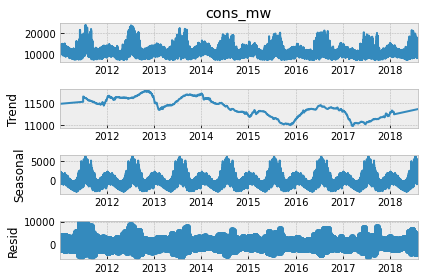

In [17]:
result.plot()
plt.show()

Looks interesting: we have very pronounced seasonality and a lot of information, not covered by season at all (residuals are of the same range, as seasonal component). This may drive us to conclusion, that we can use residuals as the new series for anomaly detection. Let's try.

In [18]:
residual_anomalies = detect_anomalies(result.resid.rename("cons_mw_res"), "30D", 3.)

In [19]:
residual_anomalies

,cons_mw_res,cons_mw_res_rmean,cons_mw_res_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,-729.580829,-729.580829,NaN,0
2011-01-01 02:00:00,-1418.700039,-1074.140434,487.280866,0
2011-01-01 03:00:00,-1832.956827,-1327.079232,557.364717,0
2011-01-01 04:00:00,-2246.598625,-1556.959080,646.902309,0
2011-01-01 05:00:00,-2384.999941,-1722.567252,671.559589,0
...,...,...,...,...
2018-08-02 20:00:00,-62.140578,-503.911701,1884.131155,0
2018-08-02 21:00:00,-538.658241,-509.317652,1878.623533,0
2018-08-02 22:00:00,-827.161064,-514.456973,1874.414025,0


In [20]:
data_an.iloc[:, :-1]

,cons_mw,cons_mw_rmean,cons_mw_rstd
dt,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN
2011-01-01 02:00:00,9273.0,9452.000000,253.144228
2011-01-01 03:00:00,9011.0,9305.000000,311.236245
2011-01-01 04:00:00,8741.0,9164.000000,379.608570
2011-01-01 05:00:00,8694.0,9070.000000,390.201230
...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713


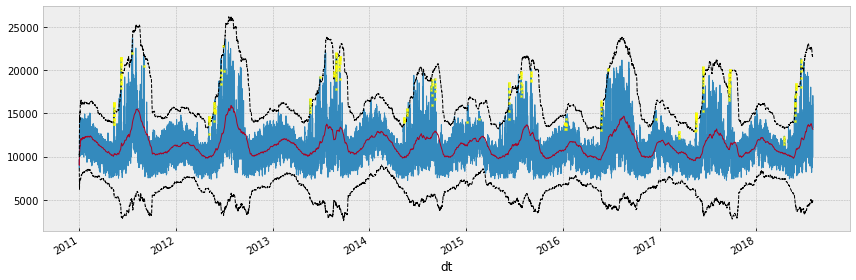

In [21]:
plot_anomalies(data_an.iloc[:, :-1].join(residual_anomalies["anomaly"]),
               "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

What is interesting, is that locations anomalies are different.

# Next steps

Can we somehow explain the anomalies? Or validate them? Yes, we can. Using the [historical weather dataset](https://www.kaggle.com/selfishgene/historical-hourly-weather-data#city_attributes.csv), we can look, whether temperature explains anomalies to some extent and then improve our anomaly detection algrithm.

In [22]:
temp_data = pd.read_csv("temperature.csv", parse_dates=["datetime"],
                        usecols=["datetime", "Chicago"], index_col="datetime")
temp_data.head()

,Chicago
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,284.010000
2012-10-01 14:00:00,284.054691
2012-10-01 15:00:00,284.177412
2012-10-01 16:00:00,284.300133


In [23]:
data_an

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN,0
2011-01-01 02:00:00,9273.0,9452.000000,253.144228,0
2011-01-01 03:00:00,9011.0,9305.000000,311.236245,0
2011-01-01 04:00:00,8741.0,9164.000000,379.608570,0
2011-01-01 05:00:00,8694.0,9070.000000,390.201230,0
...,...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596,0
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103,0
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713,0


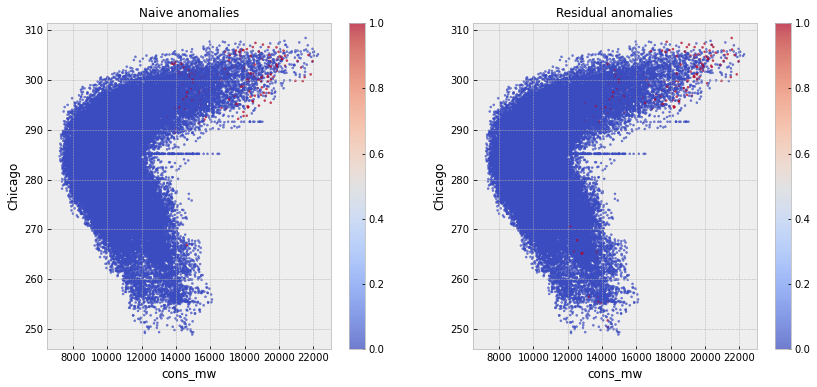

In [24]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

Btw, can you extract season (summer/winter) from this images? Try to play with some clustering here.

## Intermediate conclusions

We can make two conslusions from the plots above:

- temperature alone is a strong influencer of energy consumption,
- thus, some of the anomalies, that we detected looking only at consumption, are perfectly ok, if you add temperature into consideration.

Let's improve our detection approach, and look at both consumption and temperature. For this, we will use algorithm called Local Outlier Factor detection. In a simple terms, it looks at local density, and tryis to estimate, how strongly a point is embedded into the data.

In [25]:
from sklearn.neighbors import LocalOutlierFactor

In [26]:
en_temp = temp_data.join(data_an)[["Chicago", "cons_mw"]]

In [27]:
en_temp = en_temp[~en_temp.isnull().any(axis=1)]
en_temp

,Chicago,cons_mw
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0
...,...,...
2017-11-29 20:00:00,281.340000,12171.0
2017-11-29 21:00:00,281.690000,11998.0
2017-11-29 22:00:00,281.070000,11681.0
2017-11-29 23:00:00,280.060000,11148.0


Let's try default parameters first:

In [28]:
detector = LocalOutlierFactor()
factors = detector.fit_predict(en_temp)

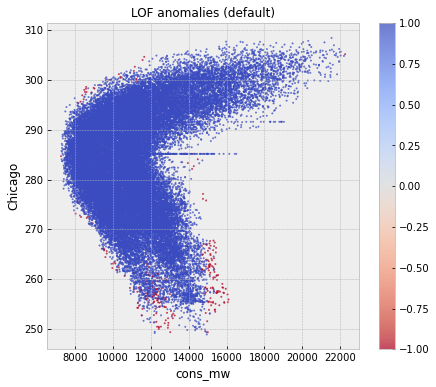

In [29]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Not that bad, but it looks like our detector is a bit too harsh. Let's make it softer:

In [30]:
soft_detector = LocalOutlierFactor(contamination=0.025, n_neighbors=10)
factors = soft_detector.fit_predict(en_temp)

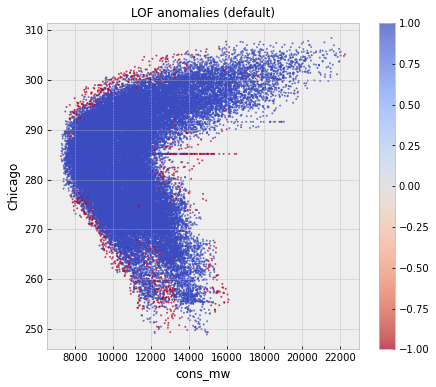

In [31]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Contamination parameter defines, how many outliers we have in the data. `0.025` means `once in 40 hours`, which is reasonable, but depends, of course, on which grid operator we consider.

Now that we looked at basics of outlier/anomaly detection, you can play with it further, for example, try IsolationForest algorithm. You may benefit from reading the discussion on how outlier is different from novelty at [`sklearn` User guide](https://scikit-learn.org/stable/modules/outlier_detection.html).

# Structural anomalies

Although you often can spot anomalies just by values, it often happens that anomalies are hidden in data structure. For example, peak frequency of the signal changes, which is sometimes quite hard to spot by eye, or some other **structural** changes take place.

In this case anomalies are detected in a more elaborate way. The most straightforward approach is to somehow quantify signal structure (power spectrum is a good example, as well as mean crossing rate).

We will not go deep into explanations of how this works from medical prospective, and will look at data itself mostly.

In [32]:
mit = pd.read_csv("234.csv")

In [33]:
mit.head()

,'sample #','MLII','V1'
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051


In [34]:
mit.columns = ["sample", "MLII", "V1"]

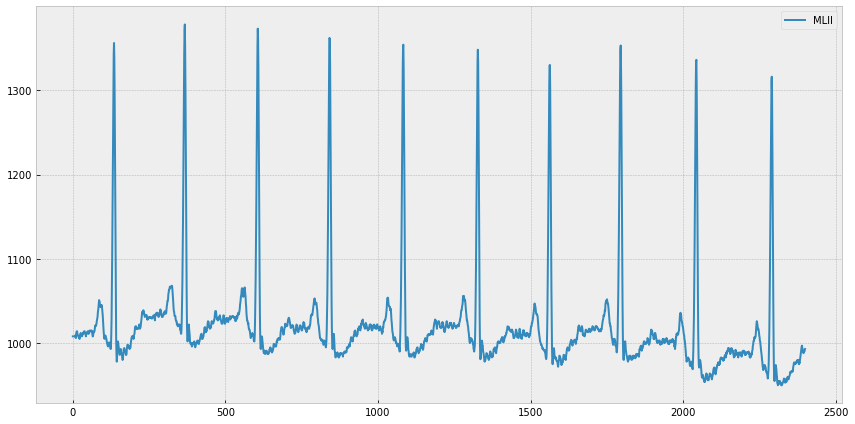

In [35]:
plt.figure(figsize=(12,6))
mit["MLII"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

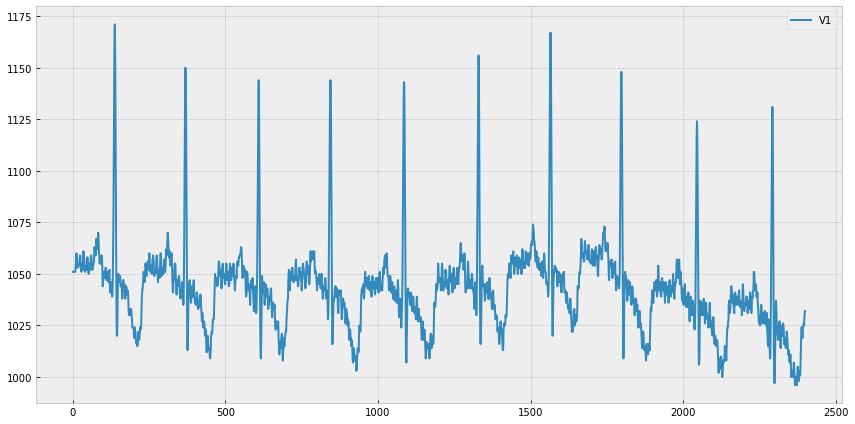

In [36]:
plt.figure(figsize=(12,6))
mit["V1"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

As you can see, data has very strong temporal pattern. Failure in following this pattern is an indication of underlying medical condition and can be detected automatically.

In [37]:
annotations = pd.read_csv("234annotations.txt", sep="\s+")

In [38]:
annotations.head()

,Time,Sample,#,Type,Sub,Chan,Num,Aux
0,0:00.144,52,+,0,0,0,(N,NaN
1,0:00.375,135,N,0,0,0,NaN,NaN
2,0:01.017,366,N,0,0,0,NaN,NaN
3,0:01.683,606,N,0,0,0,NaN,NaN
4,0:02.336,841,N,0,0,0,NaN,NaN


In [39]:
annotations.columns = ["timestamp", "sample", "type", "sub", "chan", "num", "aux", "smth"]

In [40]:
annotations = annotations[annotations.columns[:-1]]

In [41]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2764 non-null   object
 1   sample     2764 non-null   int64 
 2   type       2764 non-null   object
 3   sub        2764 non-null   int64 
 4   chan       2764 non-null   int64 
 5   num        2764 non-null   int64 
 6   aux        3 non-null      object
dtypes: int64(4), object(3)
memory usage: 151.3+ KB


In [42]:
annotations['aux'].value_counts()

(N       2
(SVTA    1
Name: aux, dtype: int64

There are many approaches to detection of structural anomalies. Depending on the signal, we can

- **construct some aggreagates for rolling windows,** and do the same thing we did with energy consumption. For example, we may calculate peak frequency, or power in some specific spectral band. This approach works well for signals, which do not have strict repetitive structure, but generally have some normal parameters. For example, for rotating (motors, generators, and so on) industrial equipment drift in peak frequency may indicate problems,
- **construct some forecasting model,** and look at large deviations between forecasts and real values. This works well for a) signals with autoregressive structure (energy consumption is a good example), and hence the model is some kind of AR model (AR, VAR, ARIMA, whatever works), b) for signals with clear and repetitive structure (ECG and EEG are good examples), and in this case we need to build a nonlinear model for forecasting.

Since we have a signal with very strict temporal pattern, we may try to model it and look at divergence between what model predicts (i.e. the temporal structure model catched) and real values.

We will take last 50 values (this number is a bit out of the blue, but if you look at signal, you'll see, that it should be ok). 
This will basicly allow us to convert our time series into a "point anomaly" problem

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [44]:
train_signal = mit[:30000]
cv_signal = mit[:30050]
test_signal = mit[40050:50000]

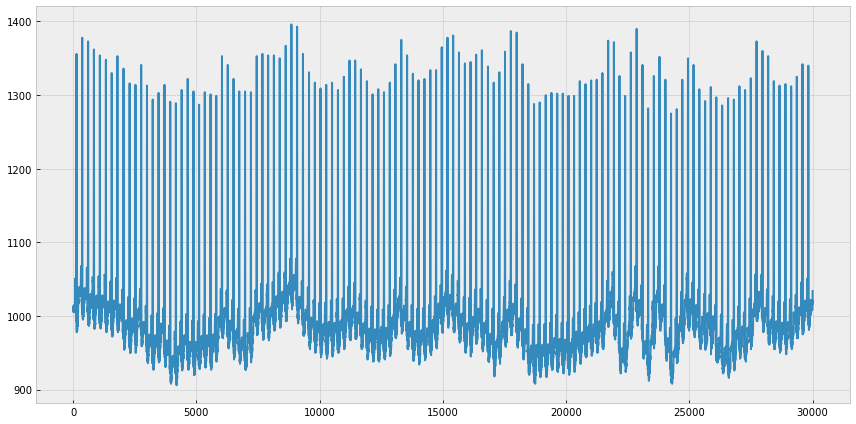

In [45]:
plt.figure(figsize=(12,6))
train_signal.MLII.plot()
plt.tight_layout()

We won't go into hyperparameters tuning, we only need to know, that our model cross-validaties.

In [46]:
WINDOW = 50

In [47]:
signal = mit[:15000]

In [48]:
features = {}

for i in signal.index[50:]:
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

In [49]:
print(features.shape)
features.head()

(14950, 100)


,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
50,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1011,1052,1012,1056,1013,1058,1013,1058,1014,1058
51,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1012,1056,1013,1058,1013,1058,1014,1058,1014,1052
52,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1013,1058,1014,1058,1014,1052,1011,1052
53,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1014,1058,1014,1052,1011,1052,1011,1050
54,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1014,1058,1014,1052,1011,1052,1011,1050,1012,1054


In [50]:
model = RandomForestRegressor(n_estimators=500, max_depth=4)
model.fit(features[:7500], signal.loc[features[:7500].index, "V1"])

RandomForestRegressor(max_depth=4, n_estimators=500)

In [51]:
print("CV MSE:", mean_squared_error(model.predict(features[7500:10000]),
                                    signal.loc[features[7500:10000].index, "V1"]))

CV MSE: 31.260694940040402


Ok, looks like it works just fine, let's look at forecasts:

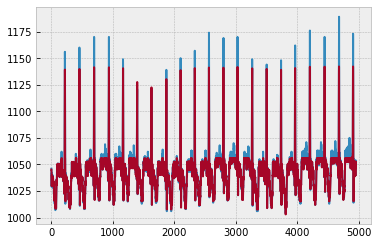

In [52]:
plt.plot(signal.loc[features[10000:].index, "V1"].values)
plt.plot(model.predict(features[10000:]))

We see, that model is not ideal, but we do not plan to use it directly. Instead, we will look at longer time intervals:

In [53]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[10000:].index, "V1"].values,
                                    model.predict(features[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features[10000:].index)

In [54]:
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

<AxesSubplot:>

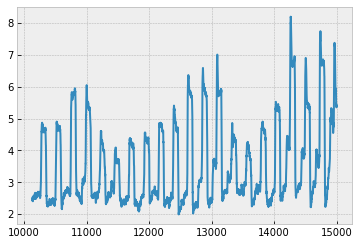

In [55]:
indicator["y_diff"].rolling(80).mean().plot()

Now, by thresholding the rolling averages difference between forecast and actual values, we can detect anomalous behaviour.

# Assignment

**Task 1 (_max score - 20 points_)** Calculate features for a longer period of time, so that the model can be trained to better match the real signal.

**Task 2 (_max score - 20 points_)** Calculate differences. Are they are ok to serve as anomaly detection?

**Task 3 (_max score - 20 points_)** Why we use rolling average instead of difference between forecast and actual values?

**Task 4 (_max score - 40 points_)** Implement the same approach (what we did from the title Structural anomalies) to the energy consumption problem.

In the tasks 2-4, visualize your results (show the anomalous points).

# Answers

### 1. Calculate features for a longer period of time, so that the model can be trained to better match the real signal

In [56]:
tested_windows = [50, 100, 200, 250, 300, 400, 500]
models = {}

for window in tested_windows:

    # Get features per window
    features_v2 = {}

    for i in signal.index[window:]:
        fts = (signal.loc[i-window:i-1, ["MLII", "V1"]]
            .reset_index(drop=True)
            .stack(dropna=False)
            .to_frame()
            .reset_index())
        fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
        features_v2[i] = fts.loc[:, 0]
    features_v2 = pd.DataFrame.from_dict(features_v2, orient="index")

    # Train model per window
    model = RandomForestRegressor(n_estimators=500, max_depth=4, random_state=0)
    model.fit(features_v2[:7500], signal.loc[features_v2[:7500].index, "V1"])
    models[window] = model
    print("Window size:", window, " CV MSE:", mean_squared_error(model.predict(features_v2[7500:10000]), 
                                                        signal.loc[features_v2[7500:10000].index, "V1"]))
                                                

Window size: 50  CV MSE: 31.757726573681577
Window size: 100  CV MSE: 30.76396418490283
Window size: 200  CV MSE: 30.57665207957974
Window size: 250  CV MSE: 30.217845296766715
Window size: 300  CV MSE: 31.09781168000316
Window size: 400  CV MSE: 31.54052676694456
Window size: 500  CV MSE: 30.898541905740746


Seems like we got the best results for window size of 250.

Let's see the results:

In [57]:
best_model = models.get(250)

features_v2 = {}

for i in signal.index[250:]:
    fts = (signal.loc[i-250:i-1, ["MLII", "V1"]]
        .reset_index(drop=True)
        .stack(dropna=False)
        .to_frame()
        .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features_v2[i] = fts.loc[:, 0]
features_v2 = pd.DataFrame.from_dict(features_v2, orient="index")

In [58]:
features_v2.head()

,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_245,V1_245,MLII_246,V1_246,MLII_247,V1_247,MLII_248,V1_248,MLII_249,V1_249
250,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1030,1056,1028,1056,1029,1052,1030,1055,1030,1055
251,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1028,1056,1029,1052,1030,1055,1030,1055,1031,1059
252,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1029,1052,1030,1055,1030,1055,1031,1059,1031,1060
253,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1030,1055,1030,1055,1031,1059,1031,1060,1030,1056
254,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1030,1055,1031,1059,1031,1060,1030,1056,1030,1053


### 2. Calculate differences. Are they are ok to serve as anomaly detection?

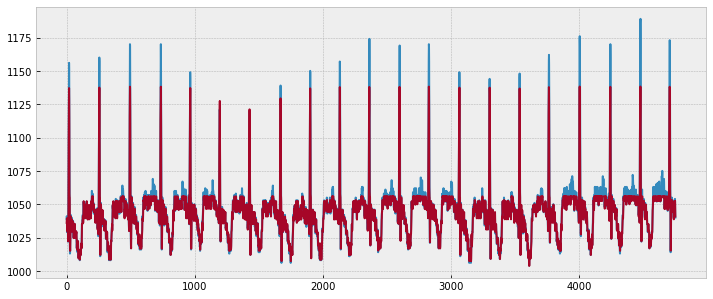

In [59]:
plt.figure(figsize=(12,5))
plt.plot(signal.loc[features_v2[10000:].index, "V1"].values)
plt.plot(best_model.predict(features_v2[10000:]))

<AxesSubplot:>

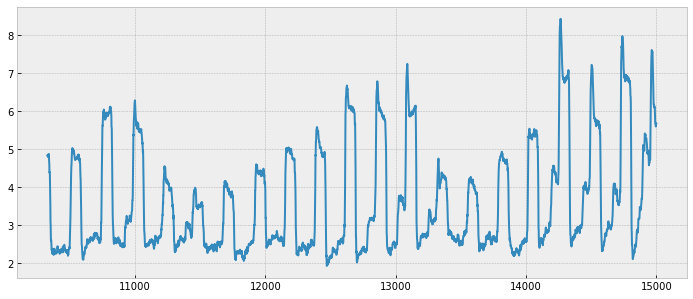

In [60]:
indicator = pd.DataFrame(np.vstack([signal.loc[features_v2[10000:].index, "V1"].values,
                                    best_model.predict(features_v2[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features_v2[10000:].index)

indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

# Lets use the rolling average here, we will explain in the next question what are the benefits of using this diff
plt.figure(figsize=(12,5))
rolling_avg_diff = indicator["y_diff"].rolling(80).mean()
rolling_avg_diff.plot()

Anomalies count: 24


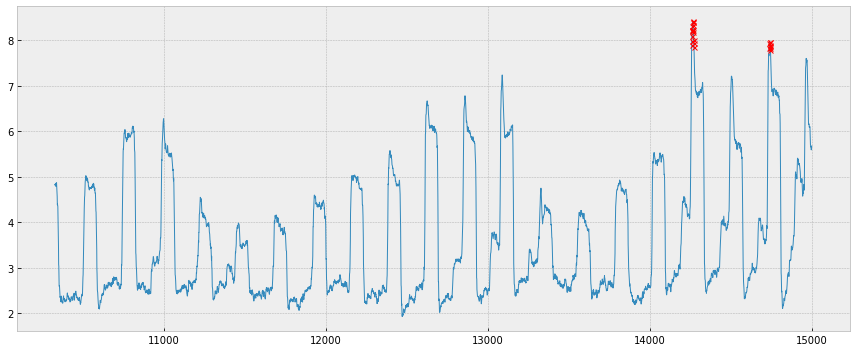

In [61]:
# Create methods for plotting the anomalies
def detect_anomalies(series, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""
    series_mean = series.mean()
    series_std = series.std()
    
    result = series.to_frame()
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

def plot_anomalies(df, d_col, a_col):
    """Plot data and annotations."""
    
    plt.figure(figsize=(12,5))
    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0, 
                                    marker="x",
                                    markersize=5,
                                    c="red")
    plt.tight_layout()

# Lets detect anomalies - 3 stds
rolling_avg_anomalies = detect_anomalies(rolling_avg_diff, 3)
detect_anomalies_count = len(rolling_avg_anomalies[rolling_avg_anomalies.anomaly == 1])

# Plotting and printing
plot_anomalies(rolling_avg_anomalies, "y_diff", "anomaly")
print(f'Anomalies count: {detect_anomalies_count}')

As we see, using the mean differences, seem to work well on the mean differences.

Let's look at the actual signal.

The signal values with the anomalies:


<AxesSubplot:>

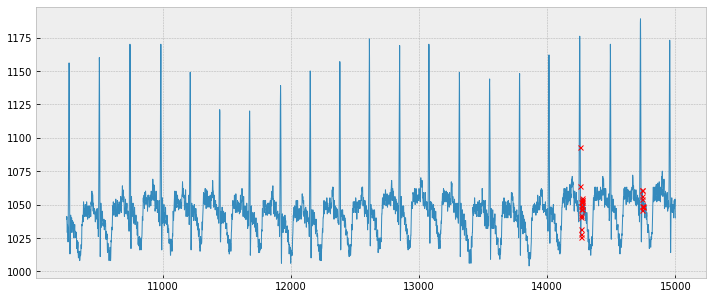

In [62]:
rolling_avg_anomalies['y_true'] = indicator["y_true"]

print("The signal values with the anomalies:")
plt.figure(figsize=(12,5))
rolling_avg_anomalies['y_true'].plot(linewidth=1)
rolling_avg_anomalies.loc[rolling_avg_anomalies["anomaly"] ==1, "y_true"].plot(linewidth=0, 
                                    marker="x",
                                    markersize=5,
                                    c="red")

##### Are they are ok to serve as anomaly detection?

When looking on the rolling average error graph the anomalies seem to be reasonable since we found anomalies on the highest peaks in the time series.

When we check the anomalies on the signal we can see a certain delta which we expect between the detection to the actual signal (which is expected due to the rolling average).

Additionally, they are not too spread on the graph, something that can imply on a decent accuracy levels or a problem in out model, though we can say that rolling avg on y_diff seems to be ok to serve as anomaly detection.

### 3. Why we use rolling average instead of difference between forecast and actual values?

Lets look on the normal differences and try to use them as anomalies instead of using the rolling average:

<AxesSubplot:>

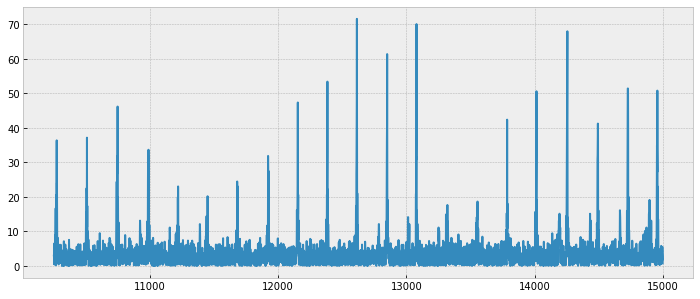

In [63]:
plt.figure(figsize=(12,5))
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()
indicator["y_diff"].plot()

Anomalies count: 89


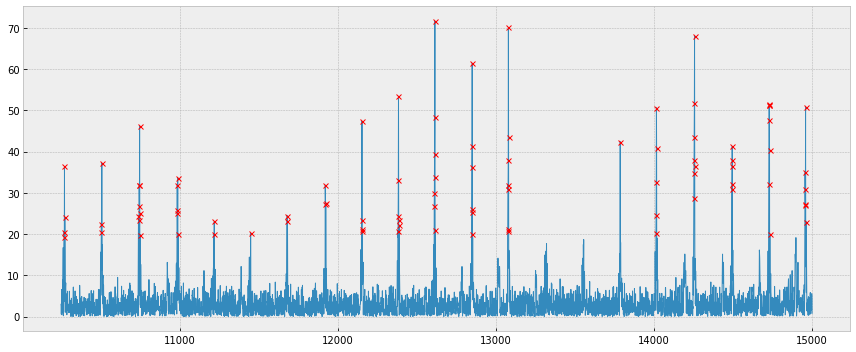

In [64]:
# Lets detect anomalies - 3 stds
diff_anomalies = detect_anomalies(indicator["y_diff"], 3)
detect_anomalies_count = len(diff_anomalies[diff_anomalies.anomaly == 1])

# Plotting and printing
plot_anomalies(diff_anomalies, "y_diff", "anomaly")
print(f'Anomalies count: {detect_anomalies_count}')

The signal values with the anomalies:


<AxesSubplot:>

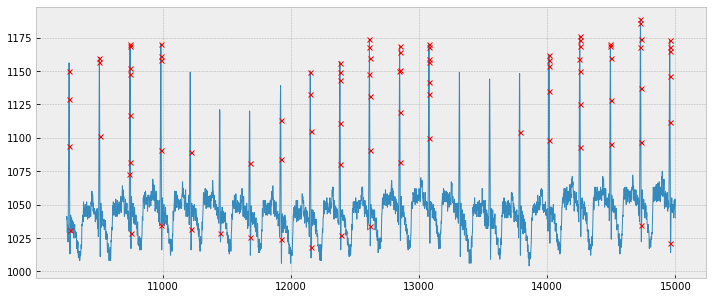

In [65]:
diff_anomalies['y_true'] = indicator["y_true"]

print("The signal values with the anomalies:")
plt.figure(figsize=(12,5))
diff_anomalies['y_true'].plot(linewidth=1)
diff_anomalies.loc[diff_anomalies["anomaly"] ==1, "y_true"].plot(linewidth=0, 
                                    marker="x",
                                    markersize=5,
                                    c="red")

This overall looks bad, let's give a couple of reasons why using the regular diff over rolling diff yields worse results:
1. One reason is that we would like to understand if the model behaves bad on a partial time series, this is due to the fact that a single wrong prediction doesn't imply directly that this is an anomaly.
2. When we are using only the differences between the prediction and real value we are not using the information we can gain from patterns over time (based on the history). 
3. We can clearly see that the diff between the prediction and actual values yields a lot of anomalies on almost every high peak, this is clearly wrong as we see it's a usual pattern of the data, using rolling average gelps us with that.

### 4. Implement the same approach (what we did from the title Structural anomalies) to the energy consumption problem.


Let's load the data:

In [66]:
df_cons = pd.read_csv('COMED_hourly.csv', 
                   parse_dates=["Datetime"],
                   index_col="Datetime")
df_cons.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
df_cons.index.name = "dt"
df_cons.head()


,cons_mw
dt,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


Short overview of the signal values:

The signal data:


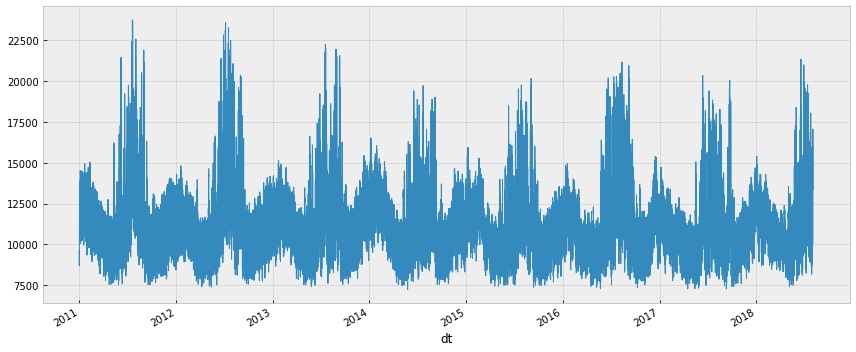

In [67]:
print("The signal data:")
plt.figure(figsize=(12,5))
df_cons['cons_mw'].plot(linewidth=1)
plt.tight_layout() 

In [68]:
# verify the sample set size
df_cons.shape

(66497, 1)

Similar to the approach before, let's split the signal samples and re-evaluate a random forest regressor predictions given a couple of selected time series windows in order to get a better intuition for the "best window size" in our case.

In [69]:
tested_windows = [
    100, 
    200, 
    250, 
    300, 
    400, 
    500]
models = {}
signal = df_cons[:15000]


for window in tested_windows:

    # Get features per window
    features_v3 = {}

    for i in range(window, 15000):
        fts = (signal[i-window:i-1][["cons_mw"]]
            .reset_index(drop=True)
            .stack(dropna=False)
            .to_frame()
            .reset_index())
        fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
        features_v3[i] = fts.loc[:, 0]
    features_v3 = pd.DataFrame.from_dict(features_v3, orient="index")

    # Train model per window
    model = RandomForestRegressor(n_estimators=500, max_depth=4, random_state=0)
    model.fit(features_v3[:12000], signal.iloc[features_v3[:12000].index]["cons_mw"])
    models[window] = model
    print("Window size:", window, " CV MSE:", mean_squared_error(model.predict(features_v3[12000:15000]), 
                                                        signal.iloc[features_v3[12000:15000].index]["cons_mw"]))
                                                

Window size: 100  CV MSE: 1121326.5881772568
Window size: 200  CV MSE: 1186333.0462006626
Window size: 250  CV MSE: 1176932.857726061
Window size: 300  CV MSE: 1162313.9662049836
Window size: 400  CV MSE: 1116057.064634921
Window size: 500  CV MSE: 1082327.9191826566


We see that out of the windows we tested, the best model is with 500 window size.

Let's evaluate the prediction diffs:

In [70]:
window = 500

# Get the best model based on the MSE we saw
best_model = models.get(window)

# Re-evaluate the features set for the given window size
features_v3 = {}

for i in range(window, 15000):
    fts = (signal[i-window:i-1][["cons_mw"]]
        .reset_index(drop=True)
        .stack(dropna=False)
        .to_frame()
        .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features_v3[i] = fts.loc[:, 0]
features_v3 = pd.DataFrame.from_dict(features_v3, orient="index")


Let's plot the signal compared to the best predictor predictions:

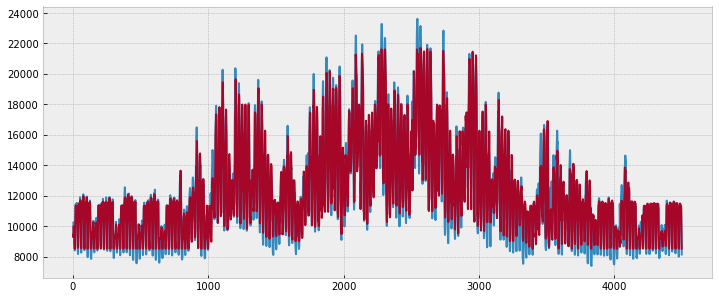

In [71]:
plt.figure(figsize=(12,5))
plt.plot(signal.iloc[features_v3[10000:].index]["cons_mw"].values)
plt.plot(best_model.predict(features_v3[10000:]))

In [72]:
# Create the diffs dataframe
indicator_v3 = pd.DataFrame(np.vstack([signal.iloc[features_v3[10000:].index]["cons_mw"].values,
                                    best_model.predict(features_v3[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features_v3[10000:].index)
indicator_v3["y_diff"] = (indicator_v3["y_true"]-indicator_v3["y_pred"]).abs()

Lets use the same approach as before with the rolling average and plot the anomalies:

Anomalies count: 30


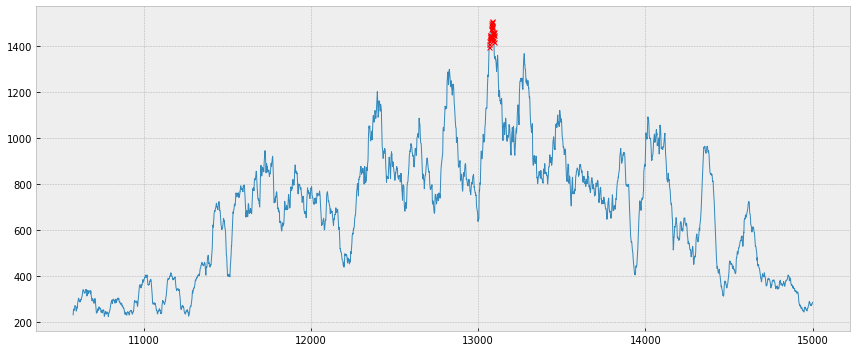

In [73]:
# Lets detect anomalies - 3 stds
rolling_avg_diff = indicator_v3["y_diff"].rolling(80).mean()
rolling_avg_anomalies = detect_anomalies(rolling_avg_diff, 2.5)
detected_anomalies_v3 = len(rolling_avg_anomalies[rolling_avg_anomalies.anomaly == 1])

# Plotting and printing
plot_anomalies(rolling_avg_anomalies, "y_diff", "anomaly")
print(f'Anomalies count: {detected_anomalies_v3}')

Let's plot the actual anomalies we found on the signal:

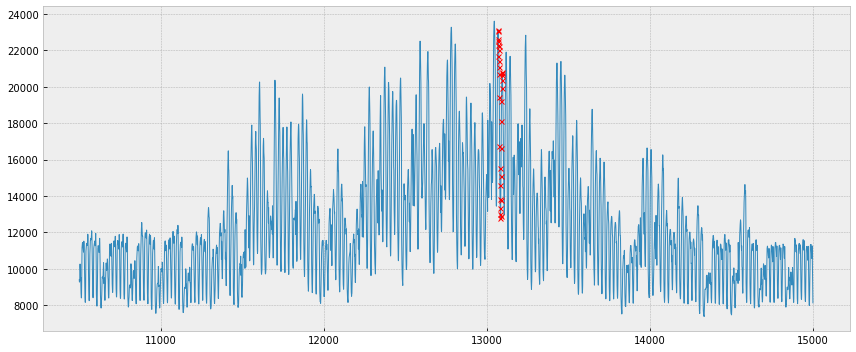

In [74]:
plt.figure(figsize=(12,5))

rolling_avg_anomalies['y_true'] = indicator_v3["y_true"]
rolling_avg_anomalies['y_true'].plot(linewidth=1, axes=plt.gca())

# Plot the anomalies
rolling_avg_anomalies.loc[rolling_avg_anomalies["anomaly"] == 1, "y_true"].plot(linewidth=0, 
                                    marker="x",
                                    markersize=5,
                                    c="red",
                                    axes=plt.gca())
plt.tight_layout()